# Analysis of complex phenotypes in patients with early hypertension

In [1]:
import warnings
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler

from analysis.cluster_analyses import (
    score_clustering, get_cluster_labels, plot_clustering,
    explain_clusters, get_embedding, to_test_cases, print_best_features
)
from analysis.data_prep import load_vasc_data
from analysis.visualization import visualize_clustering

DATA_DIR = "../data/hypertension/"
FIGS_DIR = "../figures/hypertension/"

shap.initjs()
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize": (10, 8)})

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
def print_boxplots(df):
    plt.figure(figsize=(20, 5))
    ax = sns.boxplot(data=df)
    ax.set_xticklabels([])

### We load the dataset with clinical information about patients. It's preliminarily preprocessed, i.e., column names are changed and NaN values imputed within sex and hypertension subsets.

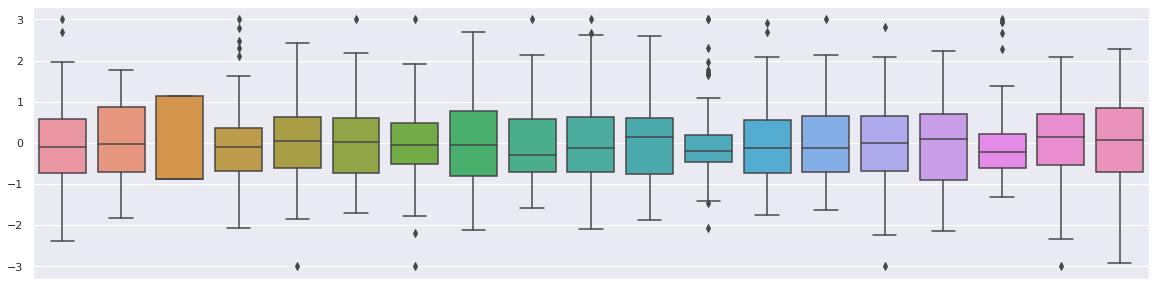

In [3]:
df = load_vasc_data(fill_na=True)
# we filter out normotensive patients as the analysis pertains to HTN ones only
df = df.loc[df.HTN_on_SBP24 == 1].reset_index(drop=True)

x = df.copy()

df.Sex = df.Sex.map({0: "male", 1: "female"})

# skewed columns are scaled
x.IPAQ = np.sqrt(x.IPAQ)
x.HR_range_day = np.sqrt(x["HR range day"])
x.PWV = np.sqrt(x.PWV)

# the data is standardized for the purpose of performing clustering
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, columns=df.columns, index=df.index)
x.drop(columns=["HTN_on_SBP24"], inplace=True)

# all values that lie further than 3 sigmas from the data mean are clipped
x.clip(lower=-3, upper=3, inplace=True)
print_boxplots(x)

## Clustering in higher-dimensional space with grid search

### We perform a gridsearch to find the best projection and its clustering. Various dim reduction algorithms and their parameters are considered.

In [4]:
reducer_grid_spec = {
    "umap": {
        "metric": [
            "manhattan", "euclidean",
            # "canberra", "braycurtis",
            "cosine", "correlation",
        ],
        "n_components": [2],
        "n_neighbors": [10, 15, 20, 25],
    },
    "tsne": {
        "n_components": [2],
        "perplexity": [15, 30, 50],
    },
    "phate": {
        "n_components": [2],
        "knn": [5, 10],
        "decay": [20, 40],
    }
}

clust_grid_spec = {
    "kmeans": {
        "n_clusters": [3, 4, 5],
    },
    # "hdbscan": {
    #     "min_cluster_size": [5, 10],
    # },
}


def run_case(curr_params):
    curr_params["reducer"] = curr_params.pop("algorithm")
    emb = get_embedding(data=x, **curr_params)

    results = []
    for clust_param_set in to_test_cases(clust_grid_spec):
        cluster_labels = get_cluster_labels(data=emb, **clust_param_set)
        clust_param_set["clust_alg"] = clust_param_set.pop("algorithm")

        score = score_clustering(emb, cluster_labels)
        results.append({
            **score,
            **curr_params,
            **clust_param_set
        })

    return results


results = Parallel(n_jobs=10, verbose=True)(
    delayed(run_case)(params) for params in to_test_cases(reducer_grid_spec))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  23 out of  23 | elapsed:   10.7s finished


### Then, all computed clustering are assessed with different scores, however the most relevant is the silhouette score

In [5]:
score_df = pd.DataFrame.from_records(chain.from_iterable(results))
score_df = score_df.sort_values(by="silhouette", ascending=False).reset_index(drop=True)
score_df

,silhouette,calinski_harabasz,davies_bouldin,label_counts,metric,n_components,n_neighbors,reducer,n_clusters,clust_alg,perplexity,knn,decay
0,0.692279,561.908529,0.439807,"[36, 23, 14]",NaN,2,NaN,phate,3,kmeans,NaN,10.0,40.0
1,0.683794,524.011257,0.440634,"[36, 23, 14]",NaN,2,NaN,phate,3,kmeans,NaN,10.0,20.0
2,0.672204,472.834917,0.466930,"[36, 21, 16]",NaN,2,NaN,phate,3,kmeans,NaN,5.0,20.0
3,0.660109,464.197065,0.477524,"[36, 23, 14]",NaN,2,NaN,phate,3,kmeans,NaN,5.0,40.0
4,0.628524,523.285140,0.479777,"[18, 34, 13, 8]",NaN,2,NaN,phate,4,kmeans,NaN,5.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.346593,79.824645,0.951821,"[20, 18, 21, 14]",NaN,2,NaN,tsne,4,kmeans,15.0,NaN,NaN
65,0.341608,71.941609,0.995515,"[19, 18, 14, 22]",NaN,2,NaN,tsne,4,kmeans,30.0,NaN,NaN
66,0.340554,126.646530,1.087339,"[20, 20, 18, 15]",manhattan,2,20.0,umap,4,kmeans,NaN,NaN,NaN
67,0.337302,77.626860,0.920126,"[13, 12, 15, 16, 17]",NaN,2,NaN,tsne,5,kmeans,15.0,NaN,NaN


### The best clustering by default (or chosen one) is printed in 2D

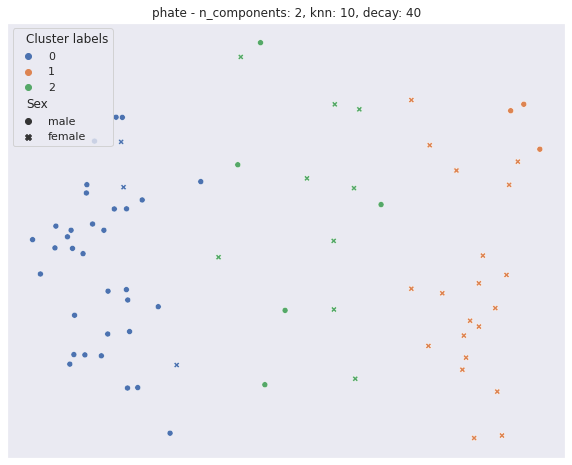

In [6]:
n = 0
params = score_df.iloc[n].to_dict()
reducer = params["reducer"]
reducer_params = {k: v if isinstance(v, str) else int(v) for k, v in params.items() if k in reducer_grid_spec[reducer]}

embedding = get_embedding(data=x, reducer=reducer, **reducer_params)

clust_alg = params["clust_alg"]
clust_alg_params = {k: int(v) for k, v in params.items() if k in clust_grid_spec[clust_alg]}
cluster_labels = get_cluster_labels(embedding, algorithm=clust_alg, **clust_alg_params)
cluster_labels.name = "Cluster labels"

if params["n_components"] == 2:
    ax = plot_clustering(embedding, cluster_labels, style=df.Sex, title=f"{reducer} - " + ", ".join(
        [f"{k}: {v}" for k, v in reducer_params.items()]
    ))
    plt.savefig(FIGS_DIR + f"clustering_{reducer}_{clust_alg}.png", bbox_inches="tight")

### At this point, the clusters are checked for their statistical significance. The boxplot figures shown below, are sorted according to the lowest p-value in ANOVA test (if there are two cluster MWU is used). Particular levels of significance are marked based on the well-known start notation.

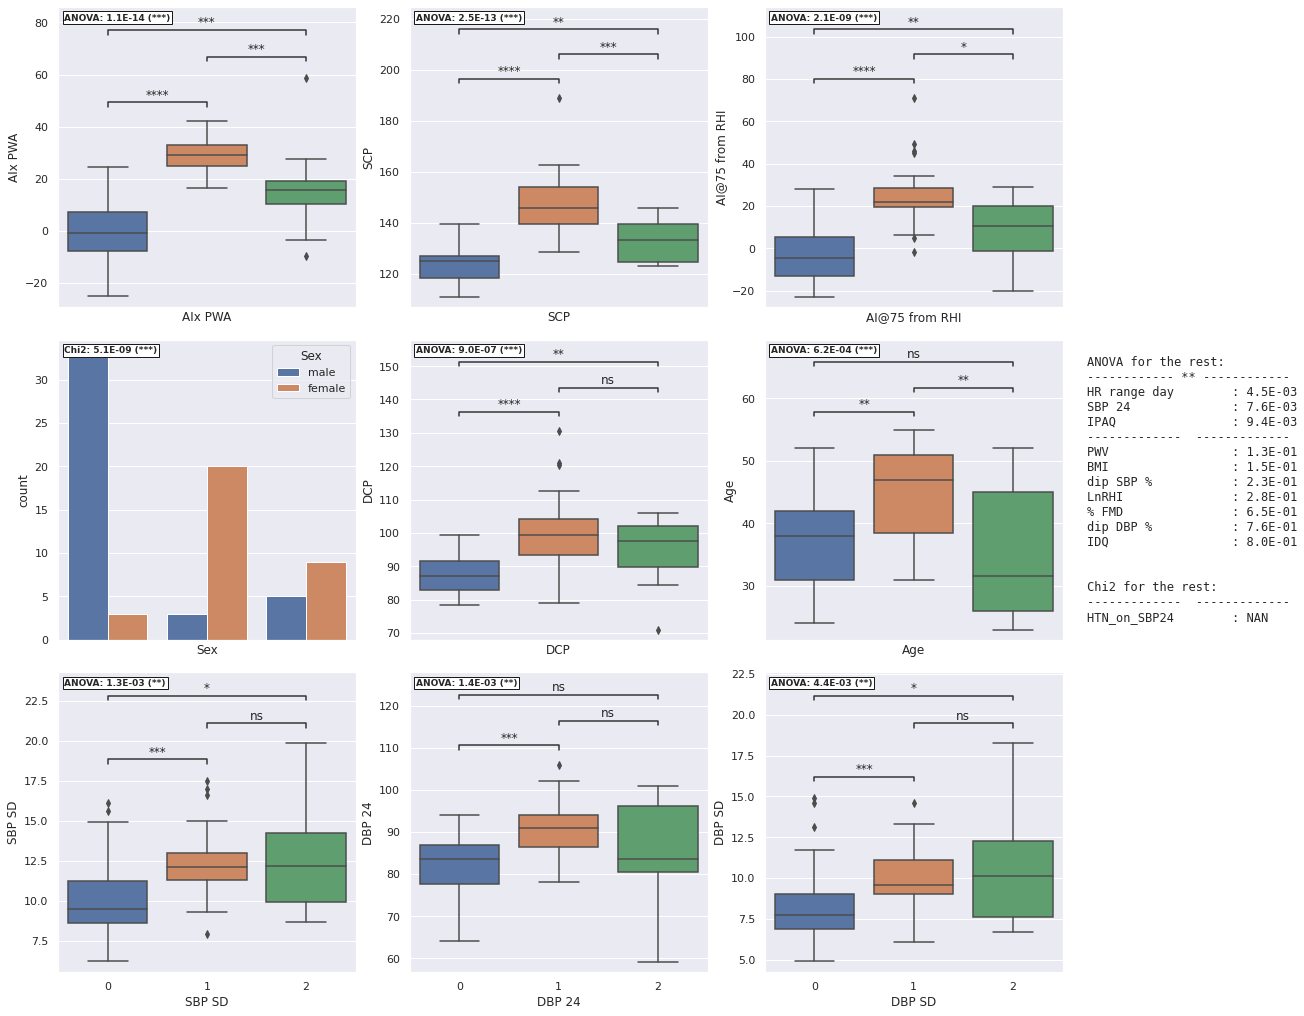

In [7]:
col_pvals = print_best_features(cluster_labels, df, categorical_cols=["HTN_on_SBP24", "Sex"])
plt.savefig(FIGS_DIR + f"clust_stats_{reducer}.png", bbox_inches="tight")

### In addition, the most significant features are printed on the clustering

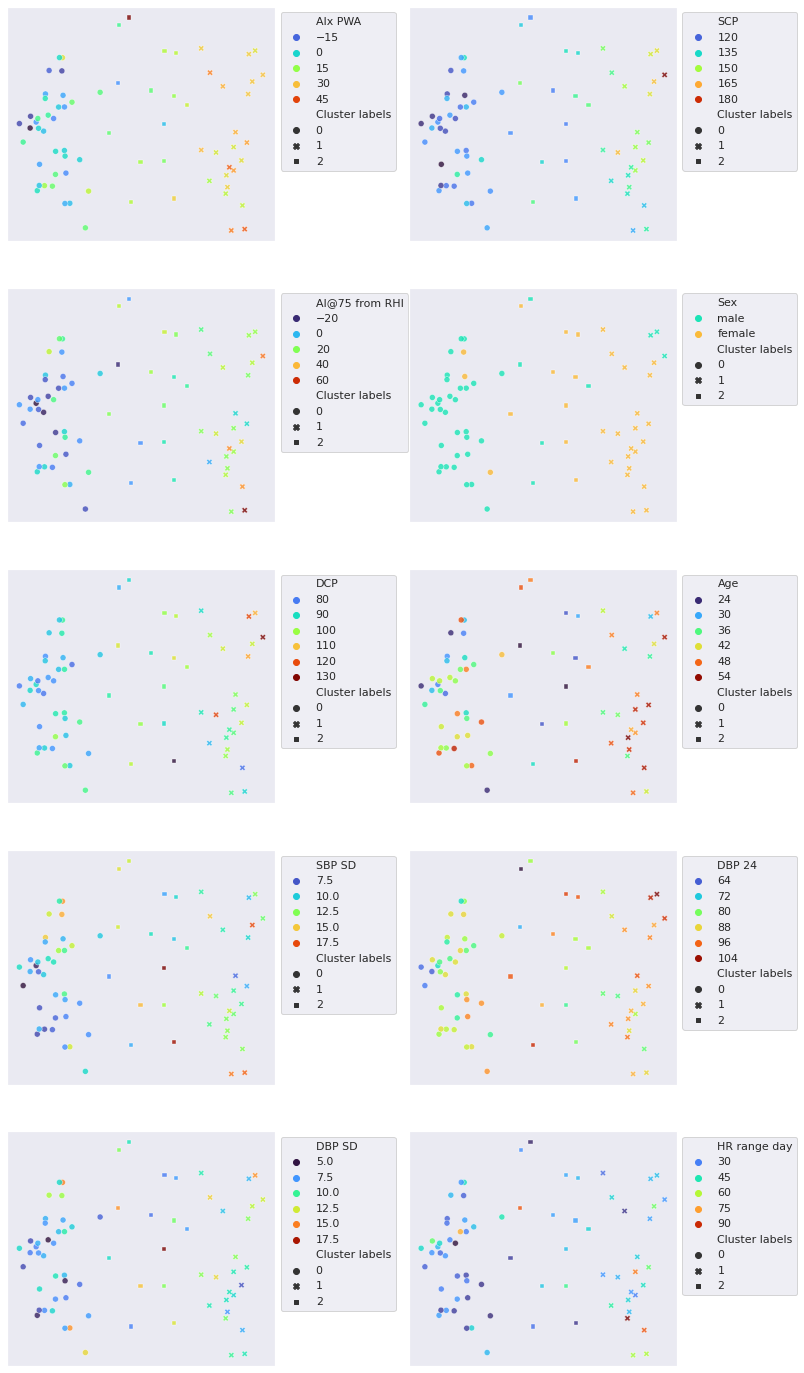

In [8]:
visualize_clustering(embedding, df[[col for col, _ in col_pvals[:10]]], cluster_labels)

### Another explainability method through SHAP values adoption is used. At first, a classifier model is build using the cluster labels as target values (XGBoost in this case). The model should be as simple as possible to give a clear view what drives particular clusters, simultaneously, the explanation accuracy (training accuracy) doesn't have to necessarily be 100% but 98-99 is enough.

Explanation accuracy: 1.0


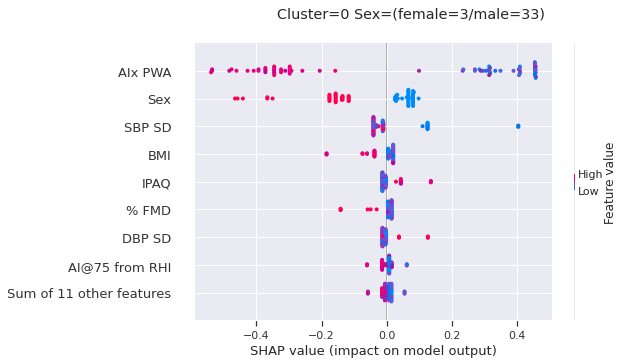

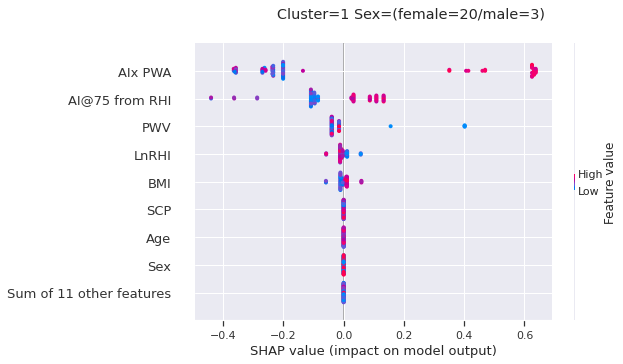

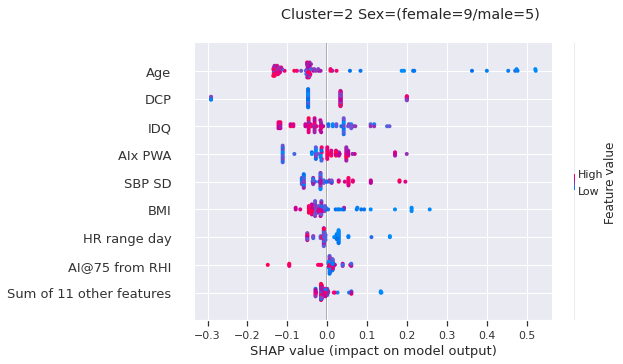

In [10]:
explain_clusters(cluster_labels, x=x, x_orig=df,
                 xgb_params=dict(n_estimators=2, max_depth=6),
                 key_feature="Sex", max_display=9,
                 out_path=FIGS_DIR, out_name="expl_cluster")